In [1]:
#!pip install datasets
from datasets import load_dataset

#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")
from sklearn.metrics import auc, roc_curve, precision_score, recall_score, precision_recall_curve

import optuna
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from xgboost import XGBClassifier


import numpy as np

/Users/mounir/Desktop/PROJETS/Statapp/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup Complete


In [2]:
ds = load_dataset("criteo/FairJob")
df = ds['train'].to_pandas()

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['click','user_id','impression_id','product_id'])
y = df['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [56]:
binary_features = X_train.columns[0:4]
categorical_features = X_train.columns[4:17]
numerical_features = X_train.columns[17:]

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# --- 1. Target Encoder perso compatible scikit-learn ---
class TargetEncoderSklearn(BaseEstimator, TransformerMixin):
    def __init__(self, min_samples=1):
        self.min_samples = min_samples
        self.global_mean = None
        self.encoding_dict = {}

    def fit(self, X, y):
        self.global_mean = y.mean()
        for col in X.columns:
            stats = y.groupby(X[col]).agg(['mean', 'count'])
            smoothing = 1 / (1 + np.exp(-(stats['count'] - self.min_samples)))
            enc = self.global_mean * (1 - smoothing) + stats['mean'] * smoothing
            self.encoding_dict[col] = enc
        return self

    def transform(self, X):
        X_enc = X.copy()
        for col in X.columns:
            X_enc[col] = X_enc[col].map(self.encoding_dict[col]).fillna(self.global_mean)
        return X_enc

# --- 2. Séparation des variables ---
binary_features = X_train.columns[0:4]
#binary_features = ['displayrandom']
categorical_features = X_train.columns[4:17]
numerical_features = X_train.columns[17:]

# Séparer catégorielles en low/high cardinality
cardinality_threshold = 10
low_card_cat = [col for col in categorical_features if X_train[col].nunique() <= cardinality_threshold]
high_card_cat = [col for col in categorical_features if col not in low_card_cat]

# --- 3. Préprocesseurs ---
preprocessor = ColumnTransformer(transformers=[
    ("binary", "passthrough", list(binary_features)),                        
    ("onehot", OneHotEncoder(drop='first', handle_unknown='ignore'), low_card_cat),
    ("target", TargetEncoderSklearn(min_samples=5), high_card_cat),                
    ("scale", StandardScaler(), list(numerical_features))                            # numériques
])

# --- 4. Pipeline complet ---
pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("logreg", LogisticRegression(max_iter=1000))
])

# --- 5. Entraînement ---
pipeline.fit(X_train, y_train)

# 1. Récupération des noms One-Hot uniquement
onehot = pipeline.named_steps['preprocessing'].named_transformers_['onehot']
onehot_feature_names = onehot.get_feature_names_out(low_card_cat)

# 2. Récupération finale des features que l'on veut interpréter
interpretable_feature_names = list(binary_features) + list(onehot_feature_names)

# 3. Les coefficients complets
coefs = pipeline.named_steps['logreg'].coef_[0]

# 4. Indices des features interprétables
all_feature_names = (
    list(binary_features) +
    list(onehot_feature_names) +
    list(high_card_cat) +  # Target Encoded — à masquer
    list(numerical_features)  # Scaled — à masquer
)

# 5. Sélection des coefficients des features interprétables
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefs
})

coef_df = coef_df[coef_df['Feature'].isin(interpretable_feature_names)]
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
display(coef_df)


,Feature,Coefficient
1,senior,0.120365
2,displayrandom,0.084046
8,cat0_5,-0.013928
16,cat1_5,-0.081674
0,protected_attribute,-0.093123
10,cat0_7,-0.169193
3,rank,-0.171299
19,cat1_8,-0.178564
9,cat0_6,-0.196020
5,cat0_2,-0.279811


In [17]:
def get_feature_names(column_transformer):
    feature_names = []

    for name, trans, cols in column_transformer.transformers_:
        if trans == "passthrough":
            feature_names.extend(cols)
        elif hasattr(trans, 'get_feature_names_out'):
            feature_names.extend(trans.get_feature_names_out(cols))
        else:
            # fallback: just return the column names
            feature_names.extend(cols)

    return feature_names


In [21]:
import statsmodels.api as sm

In [22]:
# 1. Transformer X
X_transformed = pipeline.named_steps['preprocessing'].transform(X_train)

# 2. Récupérer les noms de features
feature_names = get_feature_names(pipeline.named_steps["preprocessing"])

# 3. DataFrame avec index aligné à y_train
X_sm = pd.DataFrame(X_transformed, columns=feature_names, index=y_train.index)
X_sm = sm.add_constant(X_sm)

# 4. Régression logistique complète
model = sm.Logit(y_train, X_sm)
result = model.fit()

# 5. Résumé propre
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.036185
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  click   No. Observations:               857780
Model:                          Logit   Df Residuals:                   857713
Method:                           MLE   Df Model:                           66
Date:                Wed, 16 Apr 2025   Pseudo R-squ.:                  0.1308
Time:                        14:47:49   Log-Likelihood:                -31039.
converged:                       True   LL-Null:                       -35710.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -7.0670      0.146    -48.248      0.000      -7.354      -6.780
p

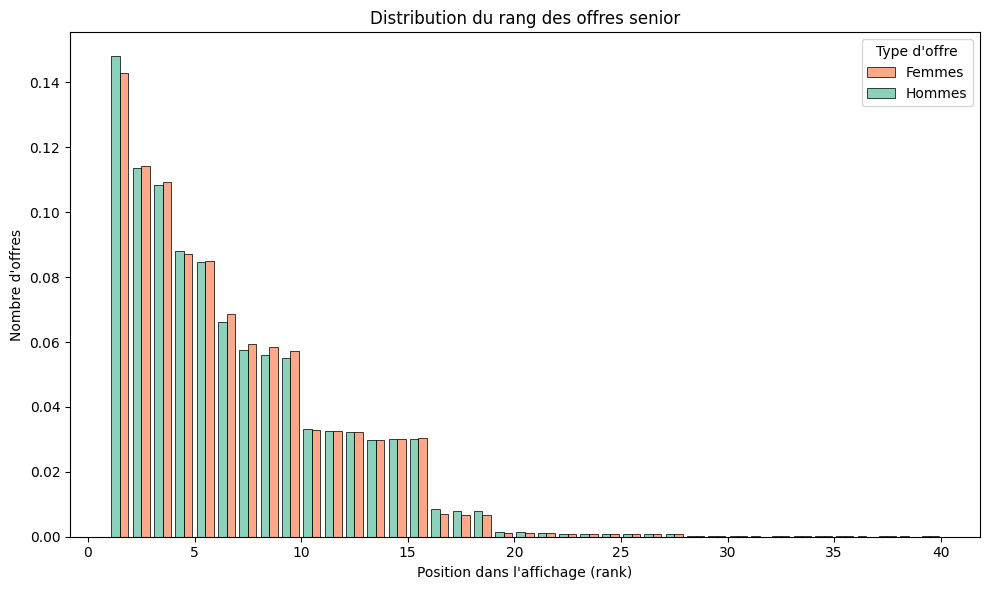

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrer les femmes
df_senior = df[df['senior'] == 1]

# Tracer les distributions de rangs selon senior/junior
plt.figure(figsize=(10, 6))
sns.histplot(data=df_senior, x='rank', hue='protected_attribute', multiple='dodge', shrink=0.8, palette='Set2', binwidth=1, stat='density', common_norm=False)

plt.title("Distribution du rang des offres senior")
plt.xlabel("Position dans l'affichage (rank)")
plt.ylabel("Nombre d'offres")
#plt.xticks(range(1, 20))
plt.legend(title="Type d'offre", labels=["Femmes", "Hommes"])
plt.tight_layout()
plt.show()


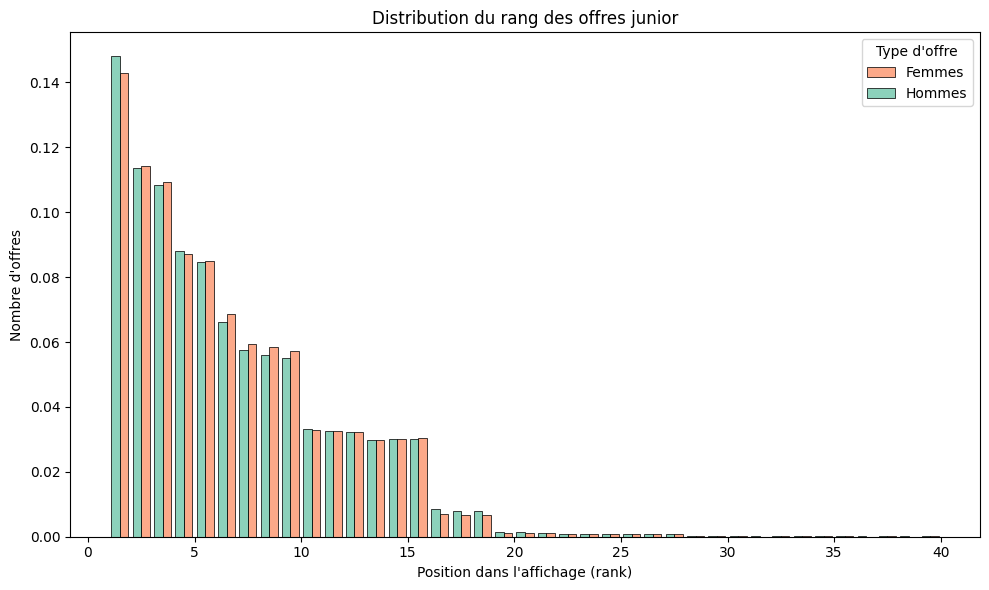

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrer les femmes
df_senior = df[df['senior'] == 1]

# Tracer les distributions de rangs selon senior/junior
plt.figure(figsize=(10, 6))
sns.histplot(data=df_senior, x='rank', hue='protected_attribute', hue_order=[0,1], multiple='dodge', shrink=0.8, palette='Set2', binwidth=1, stat='density', common_norm = False)

plt.title("Distribution du rang des offres junior")
plt.xlabel("Position dans l'affichage (rank)")
plt.ylabel("Nombre d'offres")
#plt.xticks(range(1, 20))
plt.legend(title="Type d'offre", labels=["Femmes", "Hommes"])
plt.tight_layout()
plt.show()


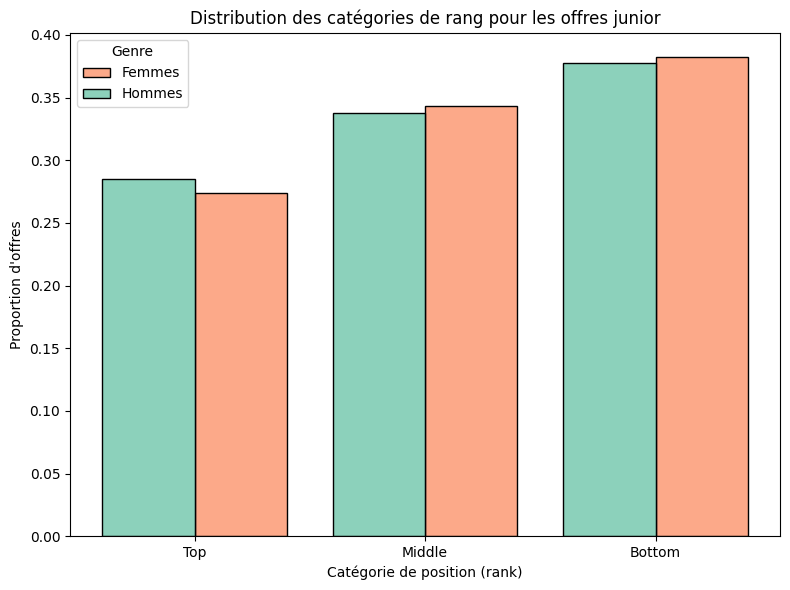

In [46]:
# Création de catégories pour le rang
df['rank_category'] = pd.cut(
    df['rank'],
    bins=[0, 3, 7, df['rank'].max() + 1],
    labels=['Top', 'Middle', 'Bottom'],
    right=False
)

# Vérification sur les offres junior
df_junior = df[df['senior'] == 0]

# Tracer la distribution des catégories de rang selon le genre (normalisé)
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df_junior,
    x='rank_category',
    hue='protected_attribute',
    hue_order=[0, 1],
    multiple='dodge',
    stat='density',
    common_norm=False,
    shrink=0.8,
    palette='Set2'
)

plt.title("Distribution des catégories de rang pour les offres junior")
plt.xlabel("Catégorie de position (rank)")
plt.ylabel("Proportion d'offres")
plt.legend(title="Genre", labels=["Femmes", "Hommes"])
plt.tight_layout()
plt.show()


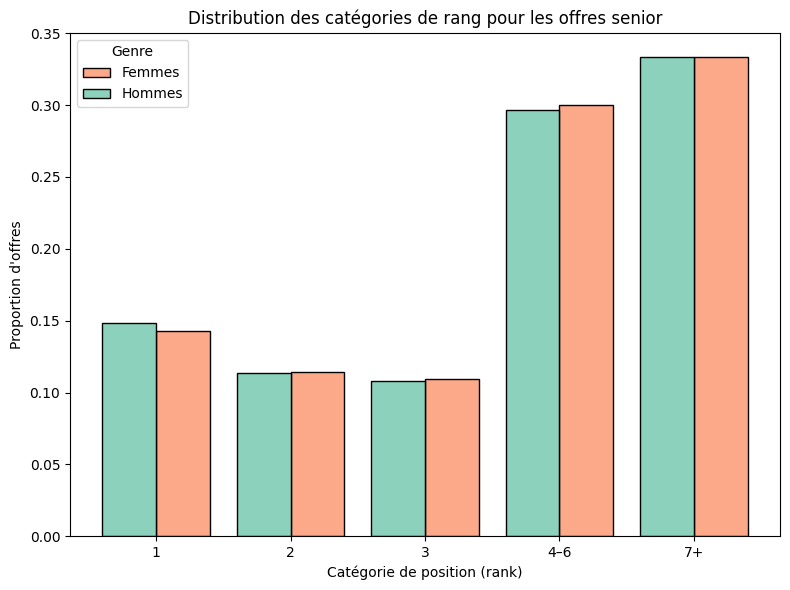

In [55]:
bins = [0, 1, 2, 3, 7, df['rank'].max() + 1]
labels = ['1', '2', '3', '4–6', '7+']

# Création de la variable catégorique pour le rang
df['rank_category'] = pd.cut(
    df['rank'],
    bins=bins,
    labels=labels,
    right=True
)


# Vérification sur les offres senior
df_junior = df[df['senior'] == 1]

# Tracer la distribution des catégories de rang selon le genre (normalisé)
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df_junior,
    x='rank_category',
    hue='protected_attribute',
    hue_order=[0, 1],
    multiple='dodge',
    stat='density',
    common_norm=False,
    shrink=0.8,
    palette='Set2'
)

plt.title("Distribution des catégories de rang pour les offres senior")
plt.xlabel("Catégorie de position (rank)")
plt.ylabel("Proportion d'offres")
plt.legend(title="Genre", labels=["Femmes", "Hommes"])
plt.tight_layout()
plt.show()
